# Logistic Regression Model on KKBox's Music Recommendation System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import accuracy_score
import re
import random
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from summary_fn import *

# 1. Loading Data

In [2]:
data = pd.read_csv('features_train_data.csv')

In [3]:
# Display the transpose of the rows to visualize all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000,
                           "display.max_columns", 1000): 
        display(df)

In [4]:
display_all(data.head().T)

,0,1,2,3,4
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=
source_system_tab,explore,my library,my library,my library,explore
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more,Explore
source_type,online-playlist,local-playlist,local-playlist,local-playlist,online-playlist
target,1,1,1,1,1
song_length,206471,284584,225396,255512,187802
artist_name,Bastille,Various Artists,Nas,Soundway,Brett Young
composer,Dan Smith| Mark Crew,NaN,N. Jones、W. Adams、J. Lordan、D. Ingle,Kwadwo Donkoh,Brett Young| Kelly Archer| Justin Ebach
lyricist,NaN,NaN,NaN,NaN,NaN


# 2. Feature engineering


#### 2.1 Data Normalizaion

In [5]:
# Normalize data
hnorm_cols = ['msno_genre_count', 'source_system_tab_user_lev_c',
              'source_screen_name_user_lev_c', 'source_type_user_lev_c',
              'composer_user_lev_c', 'lyricist_user_lev_c',
              'artist_name_user_lev_c' ]

for i in hnorm_cols:
    data[i] = data[i]/data['msno_appear_count']

In [6]:
# Fill NA's before Normalization
data.gener_count = data.gener_count.fillna(-1)

In [7]:
# Dropping less relevant columns
data.drop(columns=['lyricist_count_y','composer_count_x','gener_count'], inplace= True)

#### Column level normalization results in poor results hence not used.

In [8]:
# Normalize data at column level
norm_cols = ['song_length', 'days_left', 'registration_init_timeElapsed', 
             'expiration_Elapsed', 'song_play_counts', 'composer_count_y',
             'artist_name_count', 'source_type_count',
             'source_screen_name_count', 'source_system_tab_count',
             'artist_song_count', 'registration_init_timeYear',
             'registration_init_timeMonth', 'registration_init_timeWeek',
             'registration_init_timeDay', 'registration_init_timeDayofweek',
             'registration_init_timeDayofyear', 'expiration_Year',
             'expiration_Week', 'expiration_Day', 'expiration_Dayofweek',
             'expiration_Dayofyear', 'song_year', 'msno_appear_count']

data.loc[:,norm_cols] = (
                        data.loc[:,norm_cols]-data.loc[:,norm_cols].min())/(data.loc[:,norm_cols].max()
                                                             -data.loc[:,norm_cols].min())

#### 2.2 Data Imputation

In [9]:
# Imputing continuous columns
na_continuous_col = ['msno_genre_count', 'source_system_tab_user_lev_c',
                     'source_screen_name_user_lev_c', 'source_type_user_lev_c',
                     'artist_name_user_lev_c', 'composer_user_lev_c', 
                     'lyricist_user_lev_c']
for col in na_continuous_col:
    data[col] = data[col].fillna(-1)    

In [10]:
# Imputing categorical columns
data = data.fillna('NaN')

#### 2.3 Label encoding

In [11]:
# Label encoding for the categorical varaibles 
from sklearn import preprocessing
def encoder(x_train):
    le = preprocessing.LabelEncoder()
    for column_name in x_train.columns:
            if x_train[column_name].dtype.name in ['category','object']:
                x_train[column_name] = le.fit_transform(
                    x_train[column_name].astype(str))

# Encode the data
encoder(data)

# 3. Model fitting

#### 3.1 Train Test Split

In [12]:
# Features and target varaibles
X = data.drop(columns='target',axis=1)
y = data['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)

In [13]:
del data
del X_train_all
del y_train_all
import gc
gc.collect()

41

#### 3.2 Taking a small sample of data for our first fit

In [14]:
# Sampled data
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [15]:
# Base line model
from sklearn.metrics import accuracy_score
m = LogisticRegression()
m.fit(X_train_sampled, y_train_sampled )
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.63


#### 3.3 Feature Importance

In [16]:
def mod_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':np.abs(m.coef_[0])}
                       ).sort_values('imp', ascending=False)

fi = mod_feat_importance(m, X_train_sampled ); fi[:10]

,cols,imp
51,source_screen_name_count,0.508291
49,source_system_tab_count,0.471938
46,song_play_counts,0.410617
53,source_type_count,0.231422
54,source_type_user_lev_c,0.114698
50,source_system_tab_user_lev_c,0.112522
47,artist_song_count,0.099886
55,artist_name_count,0.099886
58,composer_user_lev_c,0.059781
2,source_system_tab,0.051079


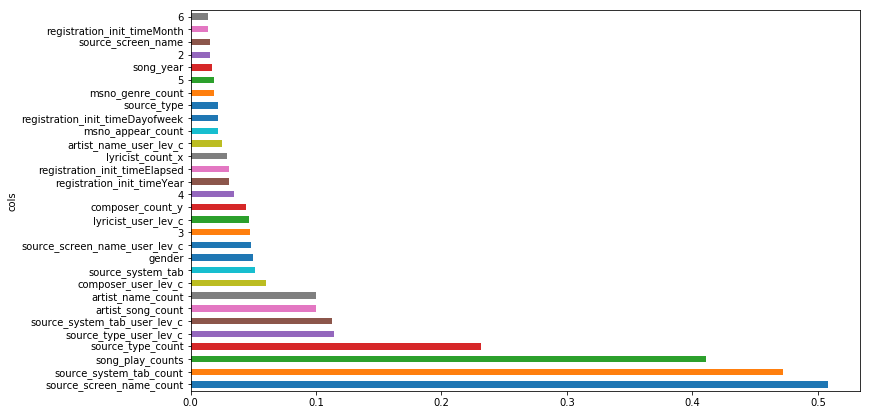

In [17]:
def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [18]:
to_keep = fi[fi.imp>0.02].cols; len(to_keep)

23

In [19]:
X_train_sampled = X_train_sampled[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]
X_train = X_train[to_keep]

#### 3.4 Grid Search

In [21]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', LogisticRegression())]) # Estimator: ML algorithm

grid_params = dict(clf__penalty=['l1', 'l2'],
                  clf__C = [.3,.5,.7,1])

gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.6383'

In [22]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
     steps=[('clf', LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
gs.best_estimator_.get_params()['clf']

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
# Fitting best model
m = LogisticRegression(C=0.3,penalty='l1', n_jobs=-1)
m.fit(X_train, y_train)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.639


In [25]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.638


# 4.  Evaluation Metric

#### 4.1 Prediction Score

In [26]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.64756581 0.63062554]
recall: [0.59492514 0.68111358]
fscore: [0.62013036 0.65489793]
support: [732119 743365]


#### 4.2 Confusion Matrix

Confusion matrix, without normalization
[[435556 296563]
 [237049 506316]]
Normalized confusion matrix
[[0.59 0.41]
 [0.32 0.68]]


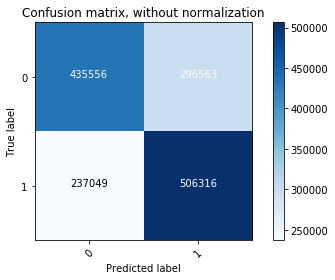

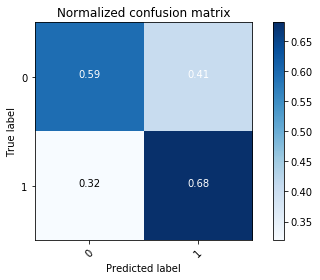

In [27]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [28]:
pd.DataFrame(predicted, columns=['LR']).to_csv('LR_test_score.csv',index=False)

#### 4.3 ROC Curve

In [29]:
# Predict probability for ROC curve
predicted = m.predict_proba(X_test)

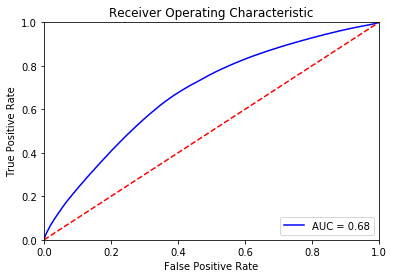

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()